来源：https://wiseodd.github.io/techblog/2015/10/24/slice-sampling/

### 介绍

除了Metropolis-Hastings和Gibbs Sampling外，Slice Sampling也是一种MCMC方法。作为MCMC方法的一种，Slice Sampling可以根据前一刻的状态生成随机样本，这些样本可以用来计算某分布的中值，期望等等。

与M-H和Gibbs Sampling不同的是，Slice Sampling不需要辅助函数，只需要需要采样的target distribution。相比之下，M-H法需要定义转移时的接受率矩阵，Gibbs Sampling需要各个变量的条件概率。

Slice Sampling的大致思路如下：假设当前的样本为$x_t$，按照如下方法生成$x_{t+1}$：

1.在$[0,f(x_t)]$直接均匀采样，得到$y$   

2.过y做一条平行于x的执行，在其位于$y=f(x)$内部的范围内的部分（slice），均匀采样得到$x_{t+1}$

![ss](ss.PNG)

从直观上来看，如某处$f(x)$的取值越大（峰越高），那么此处在采样过程中被slice覆盖的概率就越高，从这处采下个样本的概率也就越高。所以最终的效果就是越高的地方，采样越多。

在确定$y$后，若要求slice，就要解$x=f^{-1}(y)$。这里假设$f(x)$是单峰分布（unimodal），这时就比较容易实现Slice Sampling算法。

### 代码实现

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [20]:
"""
    目标分布 -- 标准正态分布
"""
def p(x):
    return np.exp(-(x**2) / 2) / (np.sqrt(2*np.pi))


"""
    标准正态分布的逆分布
"""
def p_inv(y):
    return np.sqrt(-2 * np.log(y * np.sqrt(2*np.pi)))

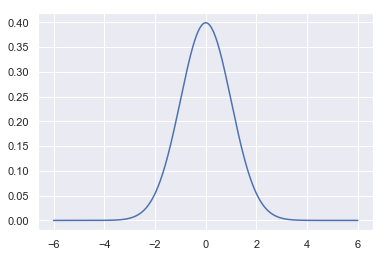

In [21]:
"""
    为标准正态分布作图
"""
p_x = np.linspace(-6, 6, 1200)
plt.plot(p_x, p(p_x))

d:\python\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


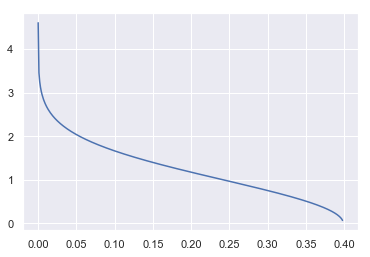

In [22]:
"""
    为标准正态分布的逆分布作图
"""
p_inv_x = np.linspace(0.00001, 0.4, 400)
plt.plot(p_inv_x, p_inv(p_inv_x))

逆分布可以帮助我们找到对应的slice，比如若f_inv(0.25)=1，那么由标准正态分布的对称性可知，此时的slice是[-1,1]。

下面的代码处理的是任意正态分布。只要修改p_inv即可。

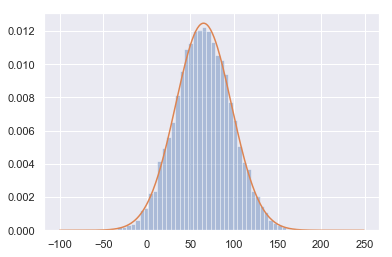

In [18]:
sns.set()
mu = 65
sigma = 32


"""
    正态分布
"""
def p(x):
    return st.norm.pdf(x, loc=mu, scale=sigma)


"""
    正态分布的逆分布
    
    第一行x是逆分布的返回值，反映的是偏离中线x=mu的多少
    所以slice就是[mu-x, mu+x]这个区段
"""
def p_inv(y):
    x = np.sqrt(-2*sigma**2 * np.log(y * sigma * np.sqrt(2*np.pi)))
    return mu-x, mu+x


"""
    Slice Sampling，共采集1000个样本
"""
def slice_sampling(iterations=1000):
    samples = np.zeros(iterations)
    x = 0

    # 可以看出是一个MCMC过程
    for i in range(iterations):
        u = np.random.uniform(0, p(x))
        x_lo, x_hi = p_inv(u)            # slice
        x = np.random.uniform(x_lo, x_hi)
        samples[i] = x

    return samples


samples = slice_sampling(10000)
sns.distplot(samples, kde=False, norm_hist=True)
x = np.arange(-100, 250)
plt.plot(x, p(x))
plt.show()

Slice Sampling是马尔可夫式（Markovian）的采样，所以相邻的两个样本之间有关联，它们并不是相互独立的。可以使用一些方法来缓解这个问题。

Slice Sampling的优点在于其不要想M-H或者Gibbs Sampling那样需要确定额外的函数。其缺点在于当要采样的分布是一般性的多峰时，slice难以确定。

若要处理高维分布，可以像Gibbs Sampling那样使用Slice Sampling依次在各个维度上进行采样。